In [ ]:
import pandas as pd
import re
import os
import time
import random
import numpy as np

try:
  %tensorflow_version 2.x # enable TF 2.x in Colab
except Exception:
  pass

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from google.colab import drive
import pickle

import spacy

nlp = spacy.load("en_core_web_sm")
from nltk.translate.bleu_score import corpus_bleu

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # enable TF 2.x in Colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [ ]:
tf.__version__

'2.3.0'

In [ ]:
# Mount drive
drive.mount('/gdrive')
drive_root = '/gdrive/My Drive/'

Mounted at /gdrive


In [ ]:
with open("\Path to dataset") as f:
  df = pickle.load(f)

In [ ]:
df.shape

(38144, 2)

In [ ]:
df.head()

,Question,Equation
963,A painter needed to paint 12 rooms in a build...,X=(7.0*(12.0-5.0))
3897,Brenda had 253 raspberry. John gripped some ra...,X = 253 - 66
27626,Casey wants to share some Bread among 17 frien...,X = 39 * 17
32530,Liza had 34 Press. Thomas furnished him some m...,X = 64 - 34
16266,George wants to distribute 125 mangos among 25...,X = 125 / 25


In [ ]:
def convert_eqn(eqn):
  elements = list(eqn)
  return ' '.join(elements)

In [ ]:
input_exps = list(df['Question'].values)

In [ ]:
target_exps = list(df['Equation'].apply(lambda x: convert_eqn(x)).values)

In [ ]:
# Input: Word Problem
input_exps[:15]

[' A painter needed to paint 12 rooms in a building. Each room takes 7 hours to paint. If he already painted 5 rooms, how much longer will he take to paint the rest? ',
 'Brenda had 253 raspberry. John gripped some raspberry. Now Brenda has 66  raspberry. How many did John grippeds?',
 'Casey wants to share some Bread among 17 friends.If each friend get 39 Bread, then how many Bread john would have?',
 'Liza had 34 Press. Thomas furnished him some more. Now Liza has 64 Press. How many did Thomas furnish him?',
 'George wants to distribute 125 mangos among 25 friends. How many would each friend acquire?',
 'Richard has 148 Marbles. Gary gave him 42 more. How many Marbles does Richard have altogether?',
 'Mary wants to impart 547 limes among 24 friends. How many would each friend obtain?',
 'Juana had some apricot. He hash each apricot into 9 slices. If total 149 apricot slices Juana make, then how many apricot Juana had?',
 'Timmy had 86 watermelon. Kandi took 40 from him. Now How many 

In [ ]:
# Target: Equation
target_exps[:15]

['X = ( 7 . 0 * ( 1 2 . 0 - 5 . 0 ) )',
 'X   =   2 5 3   -   6 6',
 'X   =   3 9   *   1 7',
 'X   =   6 4   -   3 4',
 'X   =   1 2 5   /   2 5',
 'X   =   4 2   +   1 4 8',
 'X   =   5 4 7   /   2 4',
 'X   =   1 4 9   /   9',
 'X   =   8 6   -   4 0',
 'X   =   9 9   -   6 7',
 'X = ( 2 . 0 * ( 1 4 . 0 - 7 . 0 ) )',
 'X   =   5 3 5   /   2 7',
 'X   =   1 7 0   /   2 8',
 'X   =   1 6 2   -   1 1 8',
 'X   =   2 6 3   -   2']

In [ ]:
len(pd.Series(input_exps)), len(pd.Series(input_exps).unique())

(38144, 38144)

In [ ]:
len(pd.Series(target_exps)), len(pd.Series(target_exps).unique())

(38144, 23603)

In [ ]:
def preprocess_input(sentence):
  sentence = sentence.lower().strip()
  sentence = re.sub(r"([?.!,’])", r" \1 ", sentence)
  sentence = re.sub(r"([0-9])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  sentence = sentence.rstrip().strip()
  return '<start> ' + sentence + ' <end>'

In [ ]:
def preprocess_target(sentence):
  sentence = sentence.lower().strip()
  return '<start> ' + sentence + ' <end>'

In [ ]:
preprocessed_input_exps = list(map(preprocess_input, input_exps))
preprocessed_target_exps = list(map(preprocess_target, target_exps))

In [ ]:
preprocessed_input_exps[:15]

['<start> a painter needed to paint 1 2 rooms in a building . each room takes 7 hours to paint . if he already painted 5 rooms , how much longer will he take to paint the rest ? <end>',
 '<start> brenda had 2 5 3 raspberry . john gripped some raspberry . now brenda has 6 6 raspberry . how many did john grippeds ? <end>',
 '<start> casey wants to share some bread among 1 7 friends . if each friend get 3 9 bread , then how many bread john would have ? <end>',
 '<start> liza had 3 4 press . thomas furnished him some more . now liza has 6 4 press . how many did thomas furnish him ? <end>',
 '<start> george wants to distribute 1 2 5 mangos among 2 5 friends . how many would each friend acquire ? <end>',
 '<start> richard has 1 4 8 marbles . gary gave him 4 2 more . how many marbles does richard have altogether ? <end>',
 '<start> mary wants to impart 5 4 7 limes among 2 4 friends . how many would each friend obtain ? <end>',
 '<start> juana had some apricot . he hash each apricot into 9 sli

In [ ]:
preprocessed_target_exps[:15]

['<start> x = ( 7 . 0 * ( 1 2 . 0 - 5 . 0 ) ) <end>',
 '<start> x   =   2 5 3   -   6 6 <end>',
 '<start> x   =   3 9   *   1 7 <end>',
 '<start> x   =   6 4   -   3 4 <end>',
 '<start> x   =   1 2 5   /   2 5 <end>',
 '<start> x   =   4 2   +   1 4 8 <end>',
 '<start> x   =   5 4 7   /   2 4 <end>',
 '<start> x   =   1 4 9   /   9 <end>',
 '<start> x   =   8 6   -   4 0 <end>',
 '<start> x   =   9 9   -   6 7 <end>',
 '<start> x = ( 2 . 0 * ( 1 4 . 0 - 7 . 0 ) ) <end>',
 '<start> x   =   5 3 5   /   2 7 <end>',
 '<start> x   =   1 7 0   /   2 8 <end>',
 '<start> x   =   1 6 2   -   1 1 8 <end>',
 '<start> x   =   2 6 3   -   2 <end>']

In [ ]:
def tokenize(lang):
  '''
  Tokenize the given list of strings and return the tokenized output
  along with the fitted tokenizer.
  '''
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tensor, lang_tokenizer

In [ ]:
input_tensor, inp_lang_tokenizer = tokenize(preprocessed_input_exps)

In [ ]:
(inp_lang_tokenizer.word_index)

{'.': 1,
 'how': 2,
 '<start>': 3,
 '<end>': 4,
 '?': 5,
 'many': 6,
 '1': 7,
 'had': 8,
 '2': 9,
 'some': 10,
 '3': 11,
 'each': 12,
 'him': 13,
 'has': 14,
 'now': 15,
 '4': 16,
 '6': 17,
 '5': 18,
 '7': 19,
 'if': 20,
 'have': 21,
 'did': 22,
 '8': 23,
 '9': 24,
 'friends': 25,
 'slices': 26,
 ',': 27,
 '0': 28,
 'he': 29,
 'more': 30,
 'of': 31,
 'friend': 32,
 'among': 33,
 'to': 34,
 'get': 35,
 'total': 36,
 'from': 37,
 'would': 38,
 'gave': 39,
 'marbles': 40,
 'then': 41,
 'into': 42,
 'make': 43,
 'took': 44,
 'wants': 45,
 'in': 46,
 'john': 47,
 'all': 48,
 'banana': 49,
 'mango': 50,
 'the': 51,
 'there': 52,
 'does': 53,
 'share': 54,
 'were': 55,
 'his': 56,
 'bag': 57,
 'bags': 58,
 'evenly': 59,
 'hold': 60,
 'flower': 61,
 'blueberry': 62,
 'chocolate': 63,
 'pineapple': 64,
 'blackcurrant': 65,
 'biscuit': 66,
 'toy': 67,
 'nectarine': 68,
 'bread': 69,
 'lime': 70,
 'lychee': 71,
 'orange': 72,
 'peach': 73,
 'lemon': 74,
 'book': 75,
 'apple': 76,
 'up': 77,
 'wat

In [ ]:
len(inp_lang_tokenizer.word_index)

5889

In [ ]:
input_tensor

array([[   3,  106, 2456, ...,    0,    0,    0],
       [   3,  282,    8, ...,    0,    0,    0],
       [   3,  813,   45, ...,    0,    0,    0],
       ...,
       [   3,  382,   14, ...,    0,    0,    0],
       [   3,  169,    8, ...,    0,    0,    0],
       [   3,  406,    8, ...,    0,    0,    0]], dtype=int32)

In [ ]:
input_tensor[0]

array([   3,  106, 2456,  905,   34, 1155,    7,    9, 1627,   46,  106,
       1628,    1,   12, 1991,  756,   19,  589,   34, 1155,    1,   20,
         29,  824, 2255,   18, 1627,   27,    2,  146, 1275,  274,   29,
         98,   34, 1155,   51,  594,    5,    4,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

In [ ]:
target_tensor, targ_lang_tokenizer = tokenize(preprocessed_target_exps)

In [ ]:
(targ_lang_tokenizer.word_index)

{'(': 20,
 ')': 21,
 '*': 18,
 '+': 17,
 '-': 12,
 '.': 19,
 '/': 14,
 '0': 11,
 '1': 5,
 '2': 6,
 '3': 7,
 '4': 8,
 '5': 10,
 '6': 9,
 '7': 13,
 '8': 15,
 '9': 16,
 '<end>': 3,
 '<start>': 2,
 '=': 1,
 '_': 29,
 'a': 28,
 'b': 38,
 'c': 34,
 'd': 37,
 'e': 22,
 'f': 40,
 'g': 39,
 'h': 36,
 'i': 27,
 'j': 47,
 'k': 44,
 'l': 32,
 'm': 30,
 'n': 24,
 'o': 31,
 'p': 35,
 'q': 45,
 'r': 23,
 's': 26,
 't': 25,
 'u': 33,
 'v': 41,
 'w': 43,
 'x': 4,
 'y': 42,
 'z': 46}

In [ ]:
len(targ_lang_tokenizer.word_index)

47

In [ ]:
target_tensor

array([[2, 4, 1, ..., 0, 0, 0],
       [2, 4, 1, ..., 0, 0, 0],
       [2, 4, 1, ..., 0, 0, 0],
       ...,
       [2, 4, 1, ..., 0, 0, 0],
       [2, 4, 1, ..., 0, 0, 0],
       [2, 4, 1, ..., 0, 0, 0]], dtype=int32)

In [ ]:
target_tensor[0]

array([ 2,  4,  1, 20, 13, 19, 11, 18, 20,  5,  6, 19, 11, 12, 10, 19, 11,
       21, 21,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

In [ ]:
# Creating training and validation sets
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor,target_tensor,test_size=0.05,random_state=42)                                                                                               

In [ ]:
len(input_tensor_train)

36236

In [ ]:
len(input_tensor_val)

1908

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 32
units = 256
vocab_inp_size = len(inp_lang_tokenizer.word_index)+1
vocab_tar_size = len(targ_lang_tokenizer.word_index)+1
dropout = 0.5
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
print("BUFFER_SIZE: ",BUFFER_SIZE)
print("BATCH_SIZE: ",BATCH_SIZE)
print("steps_per_epoch: ", steps_per_epoch)
print("dropout: ", dropout)

BUFFER_SIZE:  36236
BATCH_SIZE:  64
steps_per_epoch:  566
dropout:  0.5


In [ ]:
vocab_inp_size, vocab_tar_size

(5890, 48)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 124]), TensorShape([64, 66]))

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, dropout):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    
    # Bidirectional GRU Unit
    self.gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',
                                   dropout = dropout))

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state1, state2 = self.gru(x, initial_state = hidden)
    state = [state1,state2]
    return output, state

  def initialize_hidden_state(self):
    return [tf.zeros((self.batch_sz, self.enc_units)),tf.zeros((self.batch_sz, self.enc_units))]

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE, dropout)

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # Get attention_weights
    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(100)

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    #LSTM Unit
    self.lstm = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)

    x = self.embedding(x)
    
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the LSTM
    output, state, cell_state = self.lstm(x)

    output = tf.reshape(output, (-1, output.shape[2]))

    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  # Apply a mask to paddings (0)
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir = os.path.join(drive_root, "Model/checkpoints")
checkpoint_dir = os.path.join(checkpoint_dir, "MWPs/Seq2Seq_attention")

print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir)


checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

In [ ]:
if latest:
  epoch_num = int(latest.split('/')[-1].split('-')[-1])
  checkpoint.restore(latest)
else:
  epoch_num = 0

In [ ]:
epoch_num

5

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden[0]

    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input, to ensure proper training
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 5

for epoch in range(epoch_num, EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  checkpoint.save(file_prefix = checkpoint_prefix)
  print('Saved epoch: {} at {}'.format(epoch+1, checkpoint_dir))

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [ ]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    # Preprocess the input
    sentence = preprocess_input(sentence)

    inputs = [inp_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units)),tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden[0]
    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang_tokenizer.index_word[predicted_id] + ' '

        if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
def evaluate_accuracy(inputs):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = ''
    for i in range(len(inputs.numpy()[0])):
      if inputs.numpy()[0][i] != 0: #padding token
        sentence += inp_lang_tokenizer.index_word[inputs.numpy()[0][i]] + ' '

    inputs = tf.convert_to_tensor(inputs)
    
    result = ''
    result_seq = ''
    
    hidden = [tf.zeros((1, units)),tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    
    dec_hidden = enc_hidden[0]
    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']], 0)
    
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        
        result_seq += str(predicted_id) +' '
        
        result += targ_lang_tokenizer.index_word[predicted_id] + ' '

        if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
            return result_seq, result, sentence, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)

    return result_seq, result, sentence, attention_plot

In [ ]:
dataset_val = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(1, drop_remainder=True)

In [ ]:
y_true = []
y_pred = []
acc_cnt = 0

a = 0
for (inp_val_batch, target_val_batch) in iter(dataset_val):
  a += 1
  if a % 50 == 0:
    print(a)
    print("Accuracy count: ",acc_cnt)
    print('------------------')

  target_sentence = ''
  for i in target_val_batch.numpy()[0]:
    if i!= 0:
      target_sentence += (targ_lang_tokenizer.index_word[i] + ' ')
  target_sentence = target_sentence.split('<start> ')[1]

  y_true.append([target_sentence.split(' ')])

  res_seq, res, sent, att = evaluate_accuracy(inp_val_batch)
  y_pred.append(res.split(' '))
  
  if target_sentence == res:
    acc_cnt += 1

50
Accuracy count:  44
------------------
100
Accuracy count:  90
------------------
150
Accuracy count:  138
------------------
200
Accuracy count:  186
------------------
250
Accuracy count:  235
------------------
300
Accuracy count:  283
------------------
350
Accuracy count:  331
------------------
400
Accuracy count:  378
------------------
450
Accuracy count:  424
------------------
500
Accuracy count:  474
------------------
550
Accuracy count:  523
------------------
600
Accuracy count:  570
------------------
650
Accuracy count:  617
------------------
700
Accuracy count:  666
------------------
750
Accuracy count:  712
------------------
800
Accuracy count:  760
------------------
850
Accuracy count:  805
------------------
900
Accuracy count:  853
------------------
950
Accuracy count:  901
------------------
1000
Accuracy count:  948
------------------
1050
Accuracy count:  996
------------------
1100
Accuracy count:  1043
------------------
1150
Accuracy count:  1090
----

In [ ]:
print('BLEU score: ', corpus_bleu(y_true, y_pred))

BLEU score:  0.8916300115772645


In [ ]:
print('Model accuracy: ', acc_cnt/len(input_tensor_val))

Model accuracy:  0.94916142557652


In [ ]:
check_str = ' '.join([inp_lang_tokenizer.index_word[i] for i in input_tensor_val[0] if i != 0][1:-1])

In [ ]:
check_str

'ronnie had some blackberry . he divide each blackberry into 1 3 slices . if total 1 8 9 blackberry slices ronnie make , then how many blackberry ronnie had ?'

Input: <start> ronnie had some blackberry . he divide each blackberry into 1 3 slices . if total 1 8 9 blackberry slices ronnie make , then how many blackberry ronnie had ? <end>
Predicted translation: x = 1 8 9 / 1 3 <end> 


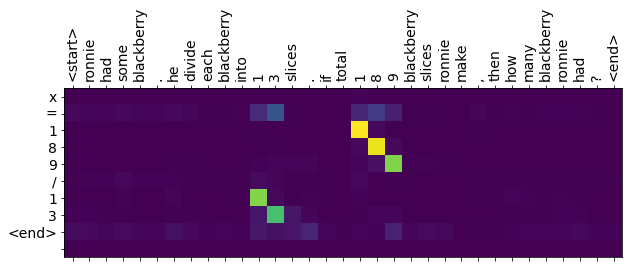

In [ ]:
translate(check_str)

Input: <start> glenn had 1 4 2 lychee . christine took 1 0 7 from him . now how many lychee glenn have left ? <end>
Predicted translation: x = 1 4 2 - 1 0 7 <end> 


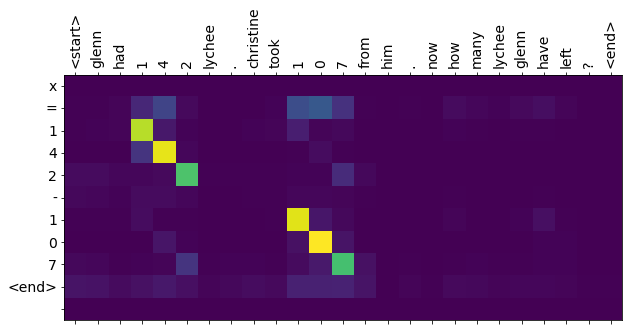

In [ ]:
translate("Glenn had 142 lychee. Christine took 107 from him. Now How many lychee Glenn have left?")

Input: <start> james procure 4 bags of mango . how many mango in each bag ? if total 5 2 mango james procure . <end>
Predicted translation: x = 5 2 / 4 <end> 


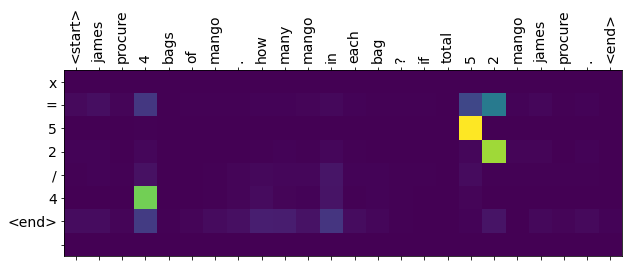

In [ ]:
translate("James procure 4 bags of Mango . how many Mango in each bag? If total 52 Mango James  procure.")

Input: <start> a dust storm sweeps across the prairie . it covers 6 4 5 3 5 acres of the prairie in dust , but leaves 5 2 2 acres untouched . how many acres does the prairie cover ? <end>
Predicted translation: x = ( 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 


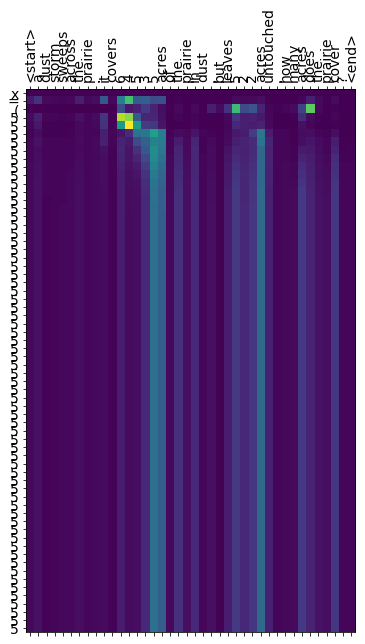

In [ ]:
translate("A dust storm sweeps across the prairie . It covers 64535 acres of the prairie in dust , but leaves 522 acres untouched . How many acres does the prairie cover ?") 

Input: <start> joanne invest 1 1 bags of orange . how many orange in each bag ? if total 7 7 orange joanne invest . <end>
Predicted translation: x = 7 7 / 1 1 <end> 


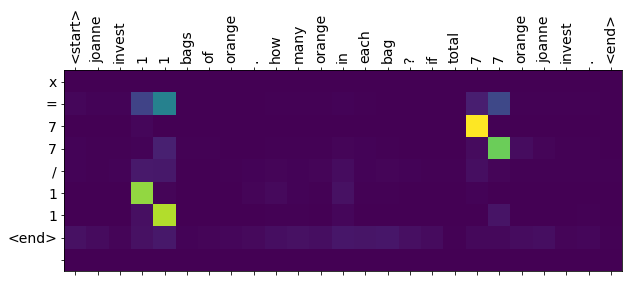

In [ ]:
translate("Joanne invest 11 bags of orange . how many orange in each bag? If total 77 orange Joanne  invest.")